In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.YAG_scans import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import *
import glob
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [22]:
fc = FileChooser('/sf/alvra/data/p19470/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19470/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [28]:
quantile_band = 0.5

channel_list = [channel_Izero117, channel_Izero122]#, channel_PSSS_y, channel_PSSS_x]

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

PIPS = []
Izero117 = []
Izero122 = []
NormPSSS = []
Spectrum_PSSS = []
PSSS_eV =[]

Signal_117 = []
Signal_122 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

    results, _ = load_data_compact(channel_list, step)
    Izero117_shot = results[channel_Izero117]
    Izero122_shot = results[channel_Izero122]
#    PSSS_shot = results[channel_PSSS_y]#.mean(axis = 0)
#    PSSS_eV = results[channel_PSSS_x].mean(axis = 0)

    df_Izero117 = pd.DataFrame(Izero117_shot)
    Izero117.append(np.quantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    df_Izero122 = pd.DataFrame(Izero122_shot)
    Izero122.append(np.quantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

#    PSSS_integral = np.mean(PSSS_shot, axis = 1)
#    df_NormPSSS = pd.DataFrame(PSSS_integral)
#    NormPSSS.append(np.quantile(df_NormPSSS, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    df_signal_norm = pd.DataFrame(Izero117_shot)# / PSSS_integral)
    Signal_117.append(np.quantile(df_signal_norm, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    df_signal122_norm = pd.DataFrame(df_Izero122)# / PSSS_integral)
    Signal_122.append(np.quantile(df_signal122_norm, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

#    Spectrum_PSSS.append(PSSS_shot.mean(axis = 0))
    
Energy_eV = Energy_eV[:np.shape(Signal_122)[0]]
    
#Spectrum_PSSS = np.asarray(np.mean(Spectrum_PSSS, axis = 0))
PSSS_eV = np.asarray(PSSS_eV)
#NormPSSS = np.asarray(NormPSSS)
Izero117 = np.asarray(Izero117)
Izero122 = np.asarray(Izero122)
PIPS = np.asarray(PIPS)

Signal_117 = np.asarray(Signal_117)
Signal_122 = np.asarray(Signal_122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))


Step 41 of 41: Processing run_025226

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 494 / 501 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 494 / 501 -> 1% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.25,0.75


In [29]:
# Normalization with the PSSS integral

Signal_117_norm = Signal_117 #Izero117 / NormP|SS
Signal_122_norm = Signal_122 #Izero122 / NormP|SS

# No normalization 

#Signal_norm = Izero117

<IPython.core.display.Javascript object>


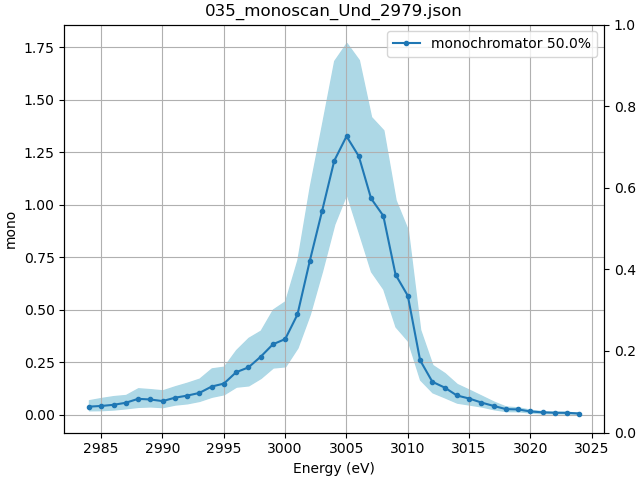

In [30]:
Int_117 = Signal_117_norm[:,0]
err_low_117 = Signal_117_norm[:,1]
err_high_117 = Signal_117_norm[:,2]

Int_122 = Signal_122_norm[:,0]
err_low_122 = Signal_122_norm[:,1]
err_high_122 = Signal_122_norm[:,2]

fig, ax1 = plt.subplots(constrained_layout=True)
ax2 = ax1.twinx()
plt.title(fc.selected_filename)

#ax2.plot(PSSS_eV, Spectrum_PSSS, label='PSSS avg spectrum', color = 'coral')
#ax1.plot(Energy_eV, Int, label='{}%'.format(quantile_band*100),marker='.')
#ax1.fill_between(Energy_eV, err_low, err_high, color='lightblue')

ax1.plot(Energy_eV, Int_122, label='monochromator {}%'.format(quantile_band*100),marker='.')
ax1.fill_between(Energy_eV, err_low_122, err_high_122, color='lightblue')

#ax2.plot(energy_vonHamos, spectrum_vonHamos, label='von Hamos', color = 'coral')
#ax2.set_xlim(3000, 3050)


ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("mono")
#ax2.set_ylabel("von Hamos")
ax1.legend(loc="best")
#ax2.legend(loc="upper left")

ax1.grid()

plt.show()

#plt.savefig(savedir+'/spectrum_compare.png')

In [31]:
spectrum_toFit = np.copy(Signal_122_norm[:,0])
Energy_eV_toFit = np.copy(Energy_eV)

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Energy_eV_toFit, spectrum_toFit)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Energy_eV_toFit,spectrum_toFit)                  # calculate the fit
spectrum_fit = fit.eval(Energy_eV_toFit)            # evaluate the curve for plotting

center = fit.popt[0]
width = fit.popt[2]*2.355

#index = ~(np.isnan(Energy_eV_toFit) | np.isnan(spectrum_toFit))

print("Center wavelength =",np.round(center,3),"eV")
print("Width =",np.abs(np.round(width,3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))

#best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)

Center wavelength = 3005.3 eV
Width = 7.676 eV
Bandwidth = 0.2554154327355006 %


<IPython.core.display.Javascript object>


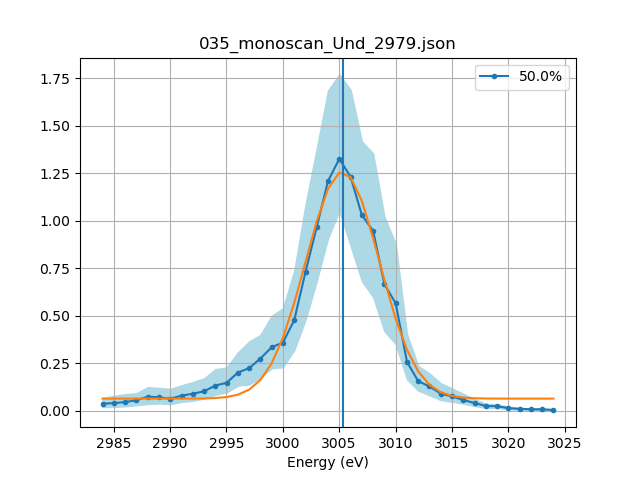

Center wavelength = 3005.3 eV
Width = 7.676 eV
Bandwidth = 0.2554154327355006 %


In [32]:
plt.figure()

plt.plot(Energy_eV, Int_122, label='{}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low_122, err_high_122, color='lightblue')

plt.plot(Energy_eV_toFit, spectrum_fit)

plt.title(fc.selected_filename)
plt.grid()
plt.xlabel("Energy (eV)")
plt.legend(loc="best")

plt.axvline(x=center)

plt.show()

print("Center wavelength =",np.round(center,3),"eV")
print("Width =",np.abs(np.round(width,3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))


In [32]:
3005.7958049652734 - 2983.7543999999994


22.04140496527407

In [11]:
0.006178*35/41.246

0.005242447752509334

<IPython.core.display.Javascript object>


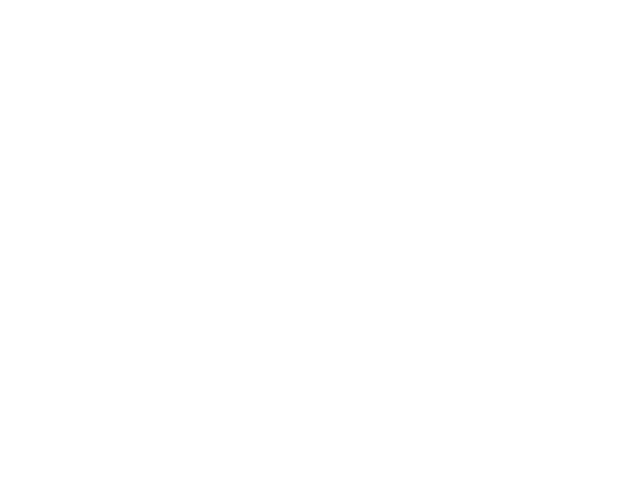

NameError: name 'Signal_norm_1' is not defined

In [41]:
plt.figure()

plt.plot(Energy_eV, Signal_norm_1, label="original",marker='.')
plt.plot(Energy_eV, Signal_norm_3, label="first try",marker='.')
plt.plot(Energy_eV, Signal_norm_2, label="second try",marker='.')

low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm


#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Energy (eV)")
plt.legend(loc="best")


plt.show()
#plt.savefig('Timescan_7_diode')